## Imports

In [2]:
!nvidia-smi

Mon Nov 28 19:56:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Download data

In [4]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

In [5]:
ls ibug_300W_large_face_landmark_dataset

afw/    image_metadata_stylesheet.xsl  labels_ibug_300W.xml
helen/  labels_ibug_300W_test.xml      lfpw/
ibug/   labels_ibug_300W_train.xml


## Visualization

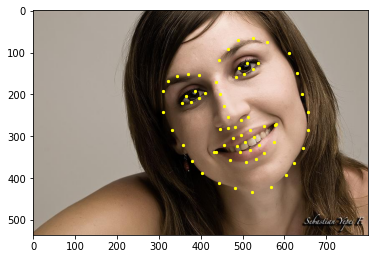

In [6]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/1030333538_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for p in points:
  x, y = p.split(' ')
  landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(6, 6))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/1030333538_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'yellow')
plt.show()

## Dataset Creation

In [7]:
class FaceLandmarkDataset(Dataset):

  def __init__(self, transform=None):

    tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
    root = tree.getroot()

    self.img_filenames = []
    self.landmarks = []
    self.crops = []
    self.transform = transform
    self.root_dir = 'ibug_300W_large_face_landmark_dataset'

    for filename in root[2]:
      self.img_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

      self.crops.append(filename[0].attrib)

      landmark = []
      for n in range(68):
        x_coor = int(filename[0][n].attrib['x'])
        y_coor = int(filename[0][n].attrib['y'])
        landmark.append([x_coor, y_coor])
      self.landmarks.append(landmark)

    self.landmarks = np.array(self.landmarks).astype('float32')


  def __len__(self):
    return len(self.img_filenames)

  def __getitem__(self, index):
    image = cv2.imread(self.img_filenames[index], 0)
    landmarks = self.landmarks[index]

    if self.transform:
      image, landmarks = self.transform(image, landmarks, self.crops[index])

    landmarks -= 0.5

    return image, landmarks

In [8]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [9]:
dataset = FaceLandmarkDataset(Transforms())

## Visualization after tranformation

In [ ]:
rnd_idx = np.random.randint(len(dataset))

image, landmarks = dataset[rnd_idx]
landmarks = (landmarks + 0.5) * 224

plt.figure(figsize=(6, 6))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8, c='yellow');

## Train/Val Split

In [11]:
bs = 64

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=4)

In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

## Model

In [14]:
class Model(nn.Module):
    def __init__(self, num_classes = 136):
        super().__init__()
        self.model_name = 'resnet18'
        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [15]:
train_loss_history = []
val_loss_history = []

In [ ]:
torch.autograd.set_detect_anomaly(True)
model = Model()
model.cuda()

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

loss_min = np.inf
epochs = 20

start_time = time.time()

for epoch in range(1, epochs + 1):
  train_loss = 0
  val_loss = 0
  acc_loss = 0

  model.train()

  for step in range(1, len(train_loader) + 1):

    images, landmarks = next(iter(train_loader))

    images = images.cuda()
    landmarks = landmarks.view(landmarks.size(0), -1).cuda()

    pred = model(images)

    optimizer.zero_grad()

    loss_curr = loss(pred, landmarks)

    loss_curr.backward()

    optimizer.step()

    train_loss += loss_curr.item()
    acc_loss += train_loss / step

    print("Train Steps: %d/%d  Loss: %.4f " % (step, len(train_loader), acc_loss))

  model.eval()
  with torch.no_grad():

    for step in range(1, len(valid_loader) + 1):
      
      images, landmarks = next(iter(valid_loader))

      images = images.cuda()
      landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
      pred = model(images)

      # find the loss for the current step
      loss_curr = loss(pred, landmarks)

      plt.figure(figsize=(6, 6))
      plt.imshow(images[0].cpu().numpy().squeeze(), cmap='gray');
      plt.scatter(pred.cpu().numpy().reshape(-1, 68, 2)[:,0] + 0.5, pred.cpu().numpy().reshape(-1, 68, 2)[:,1] + 0.5, s=8, c='yellow');
      plt.show()

      val_loss += loss_curr.item()
      acc_loss = val_loss / step

      print("Valid Steps: %d/%d  Loss: %.4f " % (step, len(valid_loader), acc_loss))


  train_loss /= len(train_loader)
  val_loss /= len(valid_loader)

  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  
  print('\n--------------------------------------------------')
  print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, train_loss, val_loss))
  print('--------------------------------------------------')
  
  if val_loss < loss_min:
      loss_min = val_loss
      torch.save(model.state_dict(), f'/content/face_landmarks_{bs}.pth') 
      print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, epochs))
      print('Model Saved\n')
    
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

axs.plot(np.arange(1, 21), train_loss_history, color='blue', label='Training Loss')
axs.plot(np.arange(1, 21), val_loss_history, color='red', label='Validation Loss')
axs.set_xlabel('# of epochs')
axs.set_ylabel('MSE')

plt.legend()
plt.savefig('loss_graph.png')

In [ ]:
torch.save(model.state_dict(), f'face_landmarks_{bs}.pth')